<h3 style="text-align: center;"><b>NLP Final Exam</b></h3>


In [0]:
import torch
from torch import nn
from torch import functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Дисклеймер про CrossEntropyLoss и NLLLoss

Обычно в PyTorch не нужно делать Softmax как последний слой модели. 

* Если Вы используете NLLLoss, то ему на вход надо давать лог вероятности, то есть выход слоя LogSoftmax. (Просто результат софтмакса, к которому применен логарифм)
* Если Вы используете CrossEntropyLoss, то применение LogSoftmax уже включено внутрь лосса, поэтому ему на вход надо подавать просто выход обычного линейного слоя без активации. По сути CrossEntropyLoss = LogSoftmax + NLLLoss

Зачем такие сложности, чтобы посчитать обычную кросс энтропию? Дело в том, что нам в любом случае придется взять логарифм от результатов софтмакса, а если делать это одной функцией, то можно сделать более устойчивую реализацию, которая даст меньшую вычислительную погрешность. 

Таким образом, если у вас в конце сети, решающей задачу классификации, стоит просто линейный слой без активации, то вам нужно использовать CrossEntropy. В notebook используется лосс CrossEntropy

# Задание 1. Создайте генератор батчей. 

В этот раз мы хотим сделать генератор, который будет максимально похож на то, что используется в реальном обучении. 

С помощью numpy вам нужно перемешать исходную выборку и выбирать из нее батчи размером batch_size, если размер выборки не делился на размер батча, то последний батч должен иметь размер меньше batch_size и состоять просто из всех оставшихся объектов. Возвращать нужно в формате (X_batch, y_batch). Необходимо написать именно генератор, то есть вместо return использовать yield. 

Хорошая статья про генераторы: https://habr.com/ru/post/132554/


**Ответ на задание - код**


In [0]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    #YOUR CODE
    for i in range (0, len(X), batch_size):
      batch_range = perm[i: i + min(batch_size,len(X)-i)]
      X_batch = X[batch_range]
      y_batch = y[batch_range]
      yield (X_batch, y_batch)

Попробуем потестировать наш код

In [0]:
from inspect import isgeneratorfunction
assert isgeneratorfunction(batch_generator), "batch_generator должен быть генератором! В условии есть ссылка на доки"

X = np.array([
              [1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]
])
y = np.array([
              1, 2, 3
])

# Проверим shape первого батча
iterator = batch_generator(X, y, 2)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (2, 3), y_batch.shape == (2,)
assert np.allclose(X_batch, X[:2]), np.allclose(y_batch, y[:2])

# Проверим shape последнего батча (их всего два)
X_batch, y_batch = next(iterator)
assert X_batch.shape == (1, 3), y_batch.shape == (1,)
assert np.allclose(X_batch, X[2:]), np.allclose(y_batch, y[2:])

# Проверим, что итерации закончились
iter_ended = False
try:
    next(iterator)
except StopIteration:
    iter_ended = True
assert iter_ended

# Еще раз проверим то, сколько батчей создает итератор
X = np.random.randint(0, 100, size=(1000, 100))
y = np.random.randint(-1, 1, size=(1000, 1))
num_iter = 0
for _ in batch_generator(X, y, 3):
    num_iter += 1
assert num_iter == (1000 // 3 + 1)

# Задание 2. Обучите модель для классификации звезд

Загрузите датасет из файла sky_data.csv, разделите его на train/test и обучите на нем нейронную сеть (архитектура ниже). Обучайте на батчах с помощью оптимизатора Adam, lr подберите сами, пробуйте что-то вроде 1e-2

Архитектура:

1. Dense Layer с relu активацией и 50 нейронами
2. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте 50%) 
3. BatchNorm
4. Dense Layer с relu активацией и 100 нейронами
5. Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте для разнообразия 50%)
6. BatchNorm
7. Выходной Dense слой c количеством нейронов, равному количеству классов

Лосс - CrossEntropy.

В датасете классы представлены строками, поэтому классы нужно закодировать. Для этого в строчке ниже объявлен dict, с помощью него и функции map превратите столбец с таргетом в целое число. Кроме того, за вас мы выделили признаки, которые нужно использовать.

### Загрузка и обработка данных

In [0]:
feature_columns = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field']
target_column = 'class'

target_mapping = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}

In [14]:
data = pd.read_csv('https://drive.google.com/uc?id=1K-8CtATw6Sv7k2dXco1fL5MAhTbKtIH3')
data['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [136]:
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [0]:
# Extract Features
X = data[feature_columns]
# Extract target
y = data[target_column]

# encode target with target_mapping
y = y.map(target_mapping).values

Нормализация фичей

In [138]:
# Просто вычтите среднее и поделитe на стандартное отклонение (с помощью пандас). Также преобразуйте всё в np.array
#<YOUR CODE>
X = (X-X.mean() /X.std())
X = np.asarray(X)
y = np.asarray(y)
X

array([[ 1.79857878e+02, -4.98757962e-01, -2.99528210e+00, ...,
         7.48410477e+02,  1.81014456e+00,  2.65140089e+02],
       [ 1.79924922e+02, -4.53165960e-01, -3.80654210e+00, ...,
         7.48410477e+02,  1.81014456e+00,  2.65140089e+02],
       [ 1.80006759e+02, -4.62265900e-01, -3.08636210e+00, ...,
         7.48410477e+02,  1.81014456e+00,  2.66140089e+02],
       ...,
       [ 1.27879114e+02,  5.10785354e+01, -3.71116210e+00, ...,
         1.34141048e+03,  8.10144558e-01,  1.60140089e+02],
       [ 1.27803703e+02,  5.11646168e+01, -3.58647210e+00, ...,
         1.34141048e+03,  8.10144558e-01,  1.61140089e+02],
       [ 1.27991564e+02,  5.12168565e+01, -3.19348210e+00, ...,
         1.34141048e+03,  8.10144558e-01,  1.61140089e+02]])

In [0]:
assert type(X) == np.ndarray and type(y) == np.ndarray, 'Проверьте, что получившиеся массивы являются np.ndarray'
assert np.allclose(y[:5], [1,1,0,1,1])
assert X.shape == (10000, 10)
assert np.allclose(X.mean(axis=0), np.zeros(10)) and np.allclose(X.std(axis=0), np.ones(10)), 'Данные не отнормированы'


Обучение

In [0]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Превратим данные в тензоры, чтобы потом было удобнее
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

#Архитектура:

"Dense Layer с relu активацией и 50 нейронами
######Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте 50%)
######BatchNorm
Dense Layer с relu активацией и 100 нейронами
######Dropout 80% (если другой keep rate дает сходимость лучше, то можно изменить) (попробуйте для разнообразия 50%)
######BatchNorm
######Выходной Dense слой c количеством нейронов, равному количеству классов "


#######Хорошо, данные мы подготовили, теперь надо объявить модель

In [143]:
import torch.optim as optim

torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential( 
    nn.Linear(10, 50), #10 signs
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.BatchNorm1d(50),
    nn.Linear(50, 100),
    nn.Dropout(p=0.5),
    nn.BatchNorm1d(100),
    nn.Linear(100, 3)   #3 output to response
)
print(model)
#Лосс - CrossEntropy.
#В датасете классы представлены строками, поэтому классы нужно закодировать. Для этого в строчке ниже объявлен dict, с помощью него и функции map превратите столбец с таргетом в целое число. Кроме того, за вас мы выделили признаки, которые нужно использовать.

loss_fn = nn.CrossEntropyLoss()
#optimizer = nn.Optimizer()
optimizer2 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer1 = optim.Adam([var1, var2], lr=0.0001)


Sequential(
  (0): Linear(in_features=10, out_features=50, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=50, out_features=100, bias=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=100, out_features=3, bias=True)
)


### Обучающий цикл

In [0]:
def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        epoch_train_losses = []
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            # На лекции мы рассказывали, что дропаут работает по-разному во время обучения и реального предсказания
            # Чтобы это учесть нам нужно включать и выключать режим обучения, делается это командой ниже
            model.train(True)
            # Посчитаем предсказание и лосс
            current_los = loss_fn(model(X_batch),y_batch)
            #torch.from_numpy(ndarray) → Tensor #YOUR CODE
            
            # зануляем градиент
            optimizer2.zero_grad() # YOUR CODE
            
            # backward
            current_los.backward()
            
            # ОБНОВЛЯЕМ веса
            optimizer2.step()  # YOUR CODE
            
            # Запишем число (не тензор) в наши батчевые лоссы
            epoch_train_losses.append(current_los.item())        
        train_losses.append(np.mean(epoch_train_losses))
        
        # Теперь посчитаем лосс на тесте
        model.train(False)
        with torch.no_grad():
            # Сюда опять же надо положить именно число равное лоссу на всем тест датасете
            test_losses.append(loss_fn(model(X_test),y_test))
            
    return train_losses, test_losses

In [0]:
def check_loss_decreased():
    print("На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]")
    s = input()
    if s.lower() == 'да':
        print("Хорошо!")
    else:
        raise RuntimeError("Можно уменьшить дропаут, уменьшить lr, поправить архитектуру, etc")

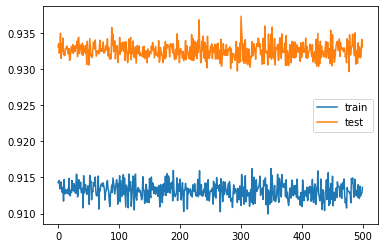

На графике сверху, точно есть сходимость? Точно-точно? [Да/Нет]
Да
Хорошо!


In [147]:
#num_epoch = 500
#num_epoch=2000 #RuntimeError: Можно уменьшить дропаут, уменьшить lr, поправить архитектуру, etc
# train_losses, test_losses = train(X_train, y_train, X_test, y_test, num_epoch) #Подберите количество эпох так, чтобы график loss сходился
# plt.plot(range(len(train_losses)), train_losses, label='train')
# plt.plot(range(len(test_losses)), test_losses, label='test')
# plt.legend()
# plt.show()


train_losses, test_losses = train(X_train, y_train, X_test, y_test, 500) #Подберите количество эпох так, чтобы график loss сходился
plt.plot(range(len(train_losses)), train_losses, label = 'train')
plt.plot(range(len(test_losses)), test_losses, label = 'test')
plt.legend()
plt.show()

    
check_loss_decreased()
assert train_losses[-1] < 0.3 and test_losses[-1] < 0.3


### Вычислите accuracy получившейся модели на train и test

In [60]:
from sklearn.metrics import accuracy_score
#TypeError: accuracy_score() missing 1 required positional argument: 'y_pred'
model.eval()
train = np.argmax(model.forward(X_train).data.numpy(), axis = 1)
test = np.argmax(model.forward(X_test).data.numpy(), axis = 1)

train_acc = accuracy_score(y_train, train)
test_acc = accuracy_score(y_test, test)


assert train_acc > 0.9, "Если уж классифицировать звезды, которые уже видел, то не хуже, чем в 90% случаев"
assert test_acc > 0.9, "Новые звезды тоже надо классифицировать хотя бы в 90% случаев"

print("Train accuracy: {}\nTest accuracy: {}".format(train_acc, test_acc))

Train accuracy: 0.9672
Test accuracy: 0.9616


# Задание 3. Исправление ошибок в архитектуре

Только что вы обучили полносвязную нейронную сеть. Теперь вам предстоит проанализировать архитектуру нейронной сети ниже, исправить в ней ошибки и  обучить её с помощью той же функции train. Пример исправления ошибок есть в семинаре Григория Лелейтнера.

Будьте осторожнее и убедитесь, что перед запуском train вы вновь переопределили все необходимые внешние переменные (train обращается к глобальным переменным, в целом так делать не стоит, но сейчас это было оправдано, так как иначе нам пришлось бы передавать порядка 7-8 аргументов).

Чтобы у вас получилась такая же архитектура, как у нас, и ответы совпали, давайте определим некоторые правила, как исправлять ошибки:

1. Если вы видите лишний нелинейный слой, который стоит не на своем месте, просто удалите его. (не нужно добавлять новые слои, чтобы сделать постановку изначального слоя разумной. Удалять надо самый последний слой, который все портит. Для линейных слоев надо что-то исправить, а не удалить его)
2. Если у слоя нет активации, то добавьте ReLU или другую подходящую активацию
3. Если что-то не так с learning_rate, то поставьте 1e-2
4. Если что-то не так с параметрами, считайте первый параметр, который появляется, как верный (т.е. далее в сети должен использоваться он).
5. Ошибки могут быть и в полносвязных слоях. 



Задача все та же - классификация небесных объектов на том же датасете. После исправления сети вам нужно обучить ее.

**Ответ на задачу - средний лосс на тестовом датасете**

In [126]:
torch.manual_seed(42)   
np.random.seed(42)
# WRONG ARCH
model = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(6, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(100, 200),
    nn.Softmax(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
    nn.Dropout(p=0.5)
)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters[:-2], lr=1e-100)

TypeError: ignored

In [0]:
# RIGHT ARCH
torch.manual_seed(42)   
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(6, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Softmax(),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 200),
    nn.Dropout(p=0.5) 
)


loss_fn =  nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


### Обучите и протестируйте модель так же, как вы это сделали в задаче 2. Вычислите accuracy.

In [0]:
#YOUR CODE
def train(X_train, y_train, num_epoch):
    for i in range(num_epoch):
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            # На лекции мы рассказывали, что дропаут работает по-разному во время обучения и реального предсказания
            # Чтобы это учесть нам нужно включать и выключать режим обучения, делается это командой ниже
            model.train(True)
            # Посчитаем предсказание и лосс
            current_los = loss_fn(model(X_batch),y_batch)
            #torch.from_numpy(ndarray) → Tensor #YOUR CODE
            
            # зануляем градиент
            optimizer.zero_grad() # YOUR CODE
            
            # backward
            current_los.backward()
            
            # ОБНОВЛЯЕМ веса
            optimizer.step()  # YOUR CODE
            

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Превратим данные в тензоры, чтобы потом было удобнее
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)
   
train(X_train, y_train, num_epoch=500)

model.eval()
train = np.argmax(model.forward(X_train).data.numpy(), axis = 1)
test = np.argmax(model.forward(X_test).data.numpy(), axis = 1)


train_acc = accuracy_score(y_train, train)
test_acc = accuracy_score(y_test, test)




 

## Задание 4. Опишите в чем заключались ошибки

## Задание 5. Опишите модель лематизации 
Необходимо описать пошагово на примере реализацию с помощью архитектуры Transformer состоящей из Encoder и Decoder